# Laboratorium 9
## Faktoryzacja QR

In [1]:
import numpy as np
from numpy.linalg import qr
import matplotlib.pyplot as plt 

In [2]:
def genMatrix(n):
    return np.random.rand(n,n)

### 1. Faktoryzacja QR metodą Grama-Schimdta

##### 1) Napisz funkcję dokonującą faktoryzacji QR, metodą  Grama Schimdta

In [3]:
def GSQR(A):
    Q, R = np.zeros(A.shape), np.zeros(A.shape)
    for k in range(A.shape[0]):
        ak = A[:, k]
        uk = ak
        for i in range(k):
            uk -= (Q[:, i]@ak)*Q[:, i]
        uk = uk/np.linalg.norm(uk)
        Q[:, k] = uk
    for i in range(A.shape[0]):
        R[i, i:] = Q[:, i] @ A[:, i:]
    return Q, R

In [4]:
A = genMatrix(5)
Q, R = GSQR(A)
print(f"Works {np.allclose(Q@R, A)}")

Works True


Funkcja GSQR - przyjmuje macierz A, zwraca macierze Q i R, będące wynikiem faktoryzacji QR. Wykorzystuje fakt, że iloczyn skalarny dwóch wektorów to iloczyn (macierzowy) wektora i kolumny (suma iloczynu odpowiednich wyrazów). Wszystko jest wyliczane zgodnie z treścią zadania, najpierw wyrazy Q, później R.

##### 2) Przetestuj zaimplementowaną metodę porównując z funkcją biblioteczną

In [5]:
def test(sizes=[50, 100, 150, 200, 250]):
    for size in sizes:
        A = genMatrix(size)
        Q1, R1 = GSQR(A)
        Q2, R2 = qr(A)
        print(f"Size {size}, Close values Q={np.allclose(np.abs(Q1), np.abs(Q2))} R={np.allclose(np.abs(R1), np.abs(R2))}")

In [6]:
test()

Size 50, Close values Q=True R=True
Size 100, Close values Q=True R=True
Size 150, Close values Q=True R=True
Size 200, Close values Q=True R=True
Size 250, Close values Q=True R=True


Jak widać funkcja działa poprawnie i zwraca bardzo podobne wyniki do funkcji bibliotecznej.

##### 3) Wygeneruj 30-50 przykładowych macierzy 8x8 o różnym wskaźniku uwarunkowania cond(A). Wykorzystać SVD oraz biblioteczną QR

cond(A) - sotsunek największej do najmniejszej wartości osobliwej.\
SVD - Singular value decomposition - otrzymujemy rozkład na 3 macierze: U, S($\Sigma$) i V\
Macierz S otrzymana dzięki SVD - Macierz diagonalna z wartościami osobliwymi na przekątnej, sterując nią możemy łatwo wpływać na współczynnik cond(A)\
U, V - macierze ortogonalne - tak samo jak macierz Q z dekompozycji QR\
Możemy rozłożyć dwie macierze i otrzymać macierze ortogonalne, i przy pomocy własnej macierzy diagonalnej wytoworzymy macierz o ustalonym cond(A)

In [7]:
def getCondMatrix(cond, n=8):
    U,_ = qr(genMatrix(n))
    V,_ = qr(genMatrix(n))
    S = np.diag(np.linspace(1, cond, n))
    return U@S@V

##### 4) Dla każdej macierzy wyznacz faktoryzację QR korzystając z zaimplementowanej funkcji, przedstaw zależność $||I-Q^TQ||$ od cond(A)

In [8]:
def cond(A):
    _,S,_ = np.linalg.svd(A)
    return S[0]/S[-1]

In [9]:
X, Y = [], []
for i in range(1, 50):
#     M = getCondMatrix(2**i)
    M = getCondMatrix(i**10)
    Q,_ = GSQR(M)
    X.append(cond(M))
    Y.append(np.linalg.norm(np.eye(M.shape[0])-Q.T@Q))

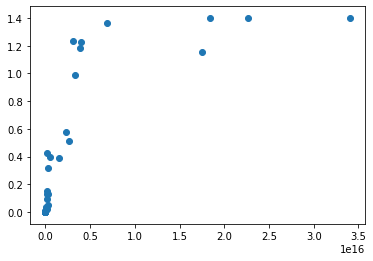

In [10]:
plt.scatter(X, Y);

Jak widać im większy wskaźnik uwarunkowania cond(A), tym większy błąd uzyskanych wyników - początkowo wzrasta bardzo dynamicznie, później wygląda jakby zaczął zbiegać do konkretnej wartości (przypomina trochę wzrosta jak $y=\sqrt x$), niemniej jednak i tak jest na tyle duży, że wyniki przestają mieć sens.\
Głównym powodem jest niedokładność obliczeń, która się kumuluje szczególnie przy wyliczaniu $u_k$ w metodzie Grama-Schimdta.

### 2. Rozwiązywanie układów równań metodą QR

Wykorzystując faktoryzację QR rozwiązać nadokreślony układ równań.\
Wykorzystując Q - orogonalne, więc $Q^T=Q^{-1}$ a także mechanizm back substitiution.\
Wykorzystać do aproskymacji średniokwadratowej dla zbioru punktów(X i Y poniżej) i modelu $f(x) = \alpha_0+\alpha_1x+\alpha_2x^2$\
Przedstaw wizualizację.

In [11]:
X = np.linspace(-5, 5, 11)
Y = np.array([2., 7., 9., 12., 13., 14., 14., 13., 10., 8., 4.]).reshape(-1, 1)

W tych wzorach X to kolumna współczynników alfa - kolumna szukana\
$AX=Y$\
równanie startowe, po rozłożeniu macierzy A przy pomocy faktoryzacji QR na macierze QR otrzymamy:\
$QRX=Y$\
Q - ortogonalna, więc $Q^{-1}=Q^T$\
$RX=Q^TY$\
R - macierz trójkątna górna, więc możemy zastosować back substitiution i wyznaczyć poszczególne wartości szukanych

In [12]:
def back(A, Y):
    M=np.hstack((A,Y))
    for i in range(M.shape[0]-1, 1, -1):
        for j in range(i):
            M[j] *= (M[i][i]/M[j][i]) # przeskalowanie wiersza
            M[j] -= M[i]
    res=[]
    for i in range(M.shape[0]):
        res.append([M[i][-1]/M[i][i]])
    
    return np.array(res)

In [13]:
def solve(X=X, Y=Y):
    A = np.array([[1, x, x*x] for x in X])
    Q,R = qr(A)
    return back(R, (Q.T@Y))

In [14]:
W=solve()

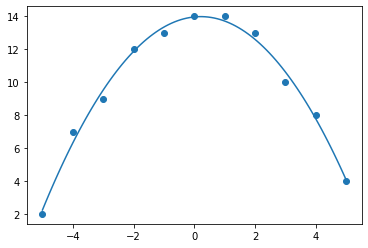

In [15]:
Xs = np.linspace(-5, 5, 100)
Ys = W[0]+W[1]*Xs+W[2]*Xs**2
plt.scatter(X, Y)
plt.plot(Xs, Ys)

Jak widać metoda bardzo dobrze pozwala aproksymować średniokwadratowo, nawet dla nie tak dobrze uwarunkowanych nadokreślonych macierzy.